<a href="https://colab.research.google.com/github/bforoura/GENAI26/blob/main/Module2/Sequential_Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a Sequential Chain**


* In the following example, we will build a multi-stage story generation and analysis workflow.

* This pattern demonstrates three critical capabilities of advanced chains:

  1.  **Primary Content Generation**: Using an initial LLM call to create raw creative content.
  
  2. **Contextual Chaining**: Feeding the output of the first stage directly into a second, specialized LLM call for evaluation.
  
  3. **State Preservation**: Transforming data through the pipeline while ensuring original inputs and intermediate results are preserved, not overwritten.

  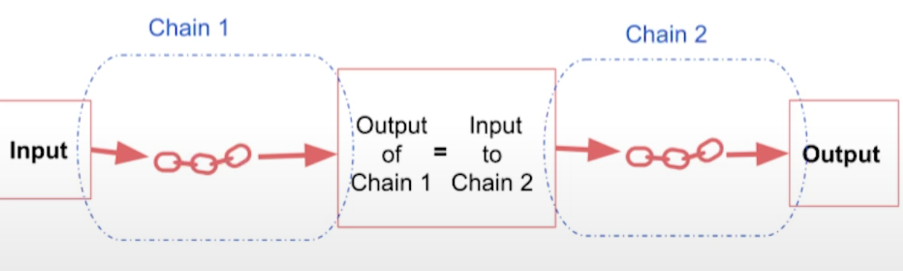



In [ ]:
# Install the needed libraries

!pip install -U q langchain-core langchain-google-genai

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

chat = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=1.0
)


# First chain generates a story
story_prompt = PromptTemplate.from_template("Write a short story about {topic}")
story_chain = story_prompt | chat | StrOutputParser()


# Second chain analyzes the story
analysis_prompt = PromptTemplate.from_template("Analyze the following story's mood:\n{story}")
analysis_chain = analysis_prompt | chat | StrOutputParser()


output_prompt = PromptTemplate.from_template(
    "Here's the story: \n{story}\n\nHere's the mood: \n{mood}"
)


# Combine chains
story_with_analysis = story_chain | analysis_chain



# Run the combined chain
result = story_with_analysis.invoke({"topic": "a rainy day"})
print(result)



The mood of this story is **deeply tranquil, contemplative, and cozy**, characterized by a sense of **liberated solitude.** 

Rather than viewing a storm as a chaotic or depressing event, the narrative treats it as a sanctuary. The mood can be broken down into several key layers:

### 1. "Cozy" Isolation (Hygge)
There is a strong sense of *hygge*—the Danish concept of coziness and comfortable conviviality that engenders a feeling of contentment. The author uses sensory details to build a "cocoon" around Elias: the "heavy ceramic mug," the "wool blanket," and the "scent of bergamot." The thunder doesn't feel threatening; instead, it makes the room feel "infinitely safer." This creates a mood of **security and warmth** contrasted against the "bruised grey" of the outside world.

### 2. Contemplative Melancholy
The mood isn't purely "happy," but rather a soft, beautiful melancholy. Phrases like "bruised grey," "soft... drumming," and the "watercolor painting" imagery suggest a world that 

# **A Probelm**

* While the above chain works, we've lost the original story in our result. **We only get the analysis**!

* The issue with the current code is a common hurdle when learning LangChain's Expression Language (**LCEL**).

* In above, **story_with_analysis = story_chain | analysis_chain**, the output of the first chain (the story text) is being passed directly as the input to the second chain.

* However, **analysis_prompt** expects a dictionary with a key named **{story}**, but it is receiving a raw string instead.

* Also, if we want the final output to include both the story and the analysis (using the output_prompt), we need a way to **keep the story data "alive"** while the analysis is being generated.

* To fix this, we should use **RunnablePassthrough** and a **dictionary structure** to ensure both pieces of data reach the final prompt.

* **RunnablePassthrough** is a core component in the LangChain Expression Language (LCEL) that acts as an **identity function**, passing the input it receives to the next step in a chain without modification


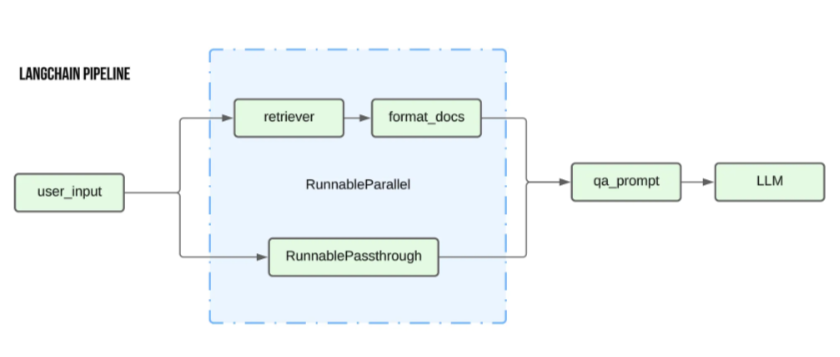


In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnablePassthrough


chat = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=1.0
)


# 1. Chains for generation and analysis
story_chain = PromptTemplate.from_template("Write a short story about {topic}") | chat | StrOutputParser()
analysis_chain = PromptTemplate.from_template("Analyze the following story's mood:\n{story}") | chat | StrOutputParser()



# 2. Final formatting prompt
output_prompt = PromptTemplate.from_template(
    "Here's the story: \n{story}\n\nHere's the mood: \n{mood}"
)



# 3. Combine using RunnablePassthrough
# We create a dictionary with 'story', then 'assign' a new 'mood' key to that same dictionary
full_chain = (
    {"story": story_chain}
    | RunnablePassthrough.assign(mood=analysis_chain)
    | output_prompt
    | chat
    | StrOutputParser()
)



# Run the combined chain
result = full_chain.invoke({"topic": "a rainy day"})
print(result)



This is a beautifully written piece of flash fiction. Your analysis of the mood is spot-on—the transition from the "brittle" tension of the heat to the "saturated" peace of the rain is executed with great sensory precision.

To build on your analysis, here are a few specific literary techniques in the story that help achieve that **"pluviophilic"** and **"restorative"** mood:

### 1. The Use of Personification and Agency
The rain and the apartment are treated as living participants in Elara’s experience. 
*   **The Rain:** It doesn't just fall; it "tests a door," "demands stillness," and grants a "permission slip." By giving the rain intent, the author makes it feel like a guest or a guardian rather than a random weather event.
*   **The Radiator:** It doesn't just click on; it "hums a low, metallic tune." This makes the environment feel like it is actively caring for her.

### 2. Contrast of Scale
The story works by shrinking the world. It starts with the "horizon" and the "city," but

# **A Final Note**

* Notice that we see a response that analyzes the story, but the actual prefix text from the output_prompt (**"Here's the story..."**) is missing.

* The reason for this is that the full_chain ends with **| chat | StrOutputParser()**.

* When we pass the formatted prompt to the LLM, the LLM reads the instructions, sees the story and mood, and then generates a new response based on them. It doesn't just print the prompt; it simply **replies** to it.

* To see the exact text you formatted—including your headers—you, remove the final chat call from the chain "**chat | StrOutputParser()**" from the end